In [275]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [276]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, 
    average_precision_score, brier_score_loss,
    confusion_matrix, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.special import logit
from scipy import stats

from statsmodels.nonparametric.smoothers_lowess import lowess
from xgboost import XGBClassifier
import warnings

In [277]:
df=pd.read_parquet('/Users/huangshifeng/Desktop/stage_III_colon_surv/data/all_cases_prepared_for_ML.parquet', engine='pyarrow')

In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Patient_ID            331 non-null    int64         
 1   Dx_Year               331 non-null    int64         
 2   Age                   331 non-null    int64         
 3   Sex                   331 non-null    int64         
 4   BMI                   327 non-null    float64       
 5   ECOG                  314 non-null    Int64         
 6   Tumor_Location        331 non-null    int64         
 7   Tumor_Location_Group  331 non-null    int64         
 8   pT_Stage              331 non-null    category      
 9   pN_Stage              331 non-null    category      
 10  AJCC_Substage         331 non-null    category      
 11  LN_Total              331 non-null    int64         
 12  LN_Positive           331 non-null    int64         
 13  LNR                 

In [279]:
features = [
    'AJCC_Substage',
    'PNI',             # 0/1
    'LNR',
    'Differentiation', # 分化程度 (Well/Mod/Poor 或 1/2/3)
]

target_col = 'edr_18m'   # 目標變數 (0/1)

In [280]:
X = df[features].copy()
y = df['edr_18m'].astype(int)

X['PNI'] = X['PNI'].astype(float)
X['Differentiation'] = X['Differentiation'].astype(float)

X = pd.get_dummies(df[features], columns=['AJCC_Substage'])

X.replace([np.inf, -np.inf], np.nan, inplace=True)

print("【資料準備完成】")
print(f"特徵矩陣形狀: {X.shape}")
print(f"缺值狀況 (補值前):\n{X.isnull().sum()[X.isnull().sum()>0]}") 
print("-" * 30)

【資料準備完成】
特徵矩陣形狀: (331, 6)
缺值狀況 (補值前):
PNI                3
Differentiation    1
dtype: int64
------------------------------


開始執行 Advanced Nested CV (包含自動調參 + 機率校準)...
這會比原本跑得慢一點，因為每個 Fold 都要做內部校準。
Processing Fold 1/5 ...
Processing Fold 2/5 ...
Processing Fold 3/5 ...
Processing Fold 4/5 ...
Processing Fold 5/5 ...

【Nested Calibration CV 最終效能】
Mean AUC: 0.7176
95% CI: 0.5814 - 0.8539
各 Fold AUC: [0.6089743589743589, 0.7800925925925926, 0.7916666666666666, 0.6751543209876543, 0.7322206095791001]
------------------------------
【各 Fold 的最佳參數】
Fold 1: {'xgb__subsample': 0.7, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 70, 'xgb__min_child_weight': 3, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.5}
Fold 2: {'xgb__subsample': 0.9, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 30, 'xgb__min_child_weight': 3, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.02, 'xgb__gamma': 0.5, 'xgb__colsample_bytree': 0.6}
Fold 3: {'xgb__subsample': 0.8, 'xgb__reg_lambda': 2, 'xgb__reg_alpha': 0.5, 'xgb__n_estimators': 30, 'xgb__min_child_wei

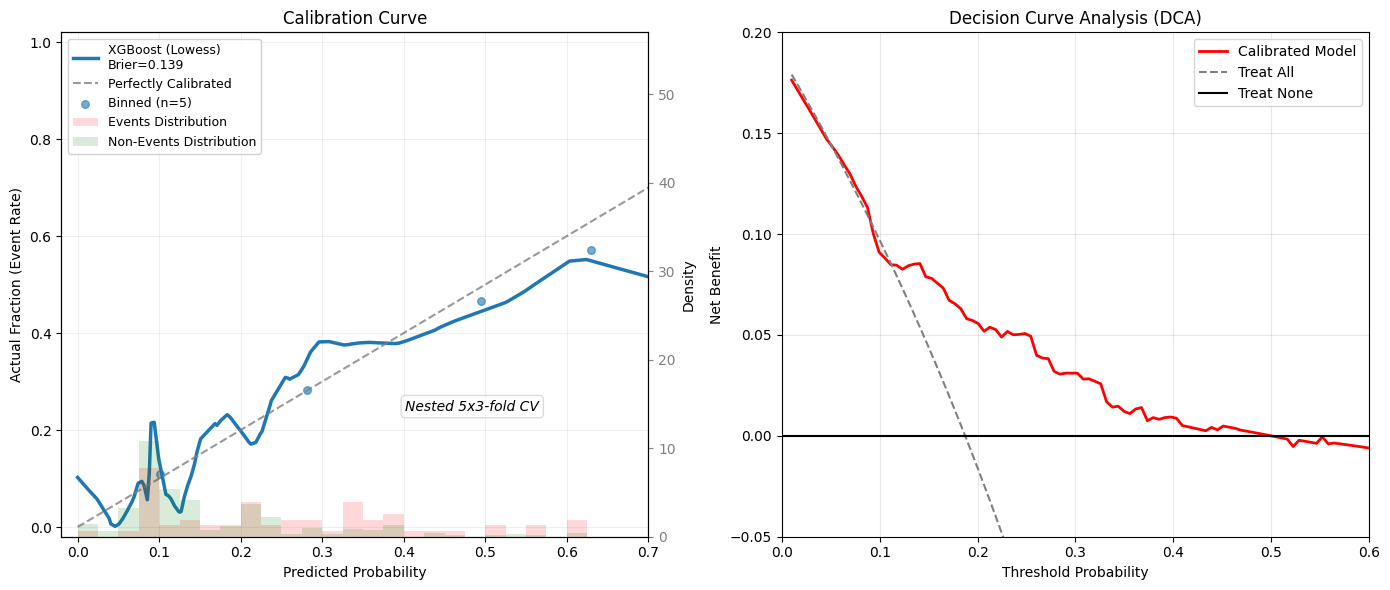

In [281]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. 準備參數網格與 CV 設定
# ==========================================
# 您的完整參數網格
param_grid_full = {
    'xgb__n_estimators': [30, 50, 70, 100, 150, 200],
    'xgb__max_depth': [2, 3, 4, 5],
    'xgb__learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1],
    'xgb__gamma': [0, 0.1, 0.5, 1],
    'xgb__min_child_weight': [1, 2, 3],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.5, 0.6, 0.7, 0.8],
    'xgb__reg_alpha': [0, 0.1, 0.5, 1],
    'xgb__reg_lambda': [1, 1.5, 2, 3]
}

# 定義基礎 Pipeline (用於搜尋參數)
ratio = float(y.value_counts()[0] / y.value_counts()[1])
pipeline_base = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('xgb', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=ratio,
        n_jobs=1
    ))
])

# 定義 CV 切分
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=8251)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=8251)

# ==========================================
# 2. 手動執行 Nested CV + Calibration (核心邏輯)
# ==========================================
print("開始執行 Advanced Nested CV (包含自動調參 + 機率校準)...")
print("這會比原本跑得慢一點，因為每個 Fold 都要做內部校準。")

nested_auc_scores = []
y_true_all = []
y_prob_calib_all = [] # 存放校準後的預測機率
best_params_list = []

# 手動迴圈跑 5 個 Folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"Processing Fold {i+1}/5 ...")
    
    # 1. 切分資料
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # 2. 【Inner Loop 1】: 找最佳參數 (Hyperparameter Tuning)
    clf = RandomizedSearchCV(
        estimator=pipeline_base,
        param_distributions=param_grid_full,
        n_iter=5000, # 測試用設 50，正式跑請改回 1000 或更多
        scoring='roc_auc',
        cv=inner_cv,
        n_jobs=-1,
        random_state=8251,
        verbose=0
    )
    clf.fit(X_train, y_train)
    best_params = clf.best_params_
    best_params_list.append(best_params)
    
    # 3. 【Inner Loop 2】: 訓練校準後的模型 (Calibration)
    # 使用找到的最佳參數，建立一個新的 XGB
    best_xgb = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=8251,
        scale_pos_weight=ratio,
        n_jobs=1,
        # 將參數解包並移除 'xgb__' 前綴
        **{k.replace('xgb__', ''): v for k, v in best_params.items()}
    )
    
    # 將 XGB 包在 CalibratedClassifierCV 中
    # cv=3 表示在 Training Set 中再切 3 份來學校準 (這樣就不會漏看答案)
    calibrated_model = CalibratedClassifierCV(best_xgb, method='isotonic', cv=3)
    
    # 放入最終 Pipeline (先補值，再進校準模型)
    final_pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('model', calibrated_model)
    ])
    
    # 4. 訓練並預測
    final_pipeline.fit(X_train, y_train)
    y_pred = final_pipeline.predict_proba(X_test)[:, 1] # 這是校準過的機率！
    
    # 5. 收集結果
    nested_auc_scores.append(roc_auc_score(y_test, y_pred))
    y_true_all.extend(y_test)
    y_prob_calib_all.extend(y_pred)

# 轉成 numpy array 方便畫圖
y_true_all = np.array(y_true_all)
y_prob_calib_all = np.array(y_prob_calib_all)

# ==========================================
# 3. 輸出結果
# ==========================================
print("\n" + "="*30)
print(f"【Nested Calibration CV 最終效能】")
print(f"Mean AUC: {np.mean(nested_auc_scores):.4f}")
print(f"95% CI: {np.mean(nested_auc_scores) - 2*np.std(nested_auc_scores):.4f} - {np.mean(nested_auc_scores) + 2*np.std(nested_auc_scores):.4f}")
print(f"各 Fold AUC: {nested_auc_scores}")

print("-" * 30)
print("【各 Fold 的最佳參數】")
for i, params in enumerate(best_params_list):
    print(f"Fold {i+1}: {params}")

# ==========================================
# 4. 畫 Calibration Curve & DCA (使用校準後的機率)
# ==========================================
brier = brier_score_loss(y, y_prob_calib_cv)
frac = 0.2
lowess_results = lowess(y, y_prob_calib_cv, frac=frac, it=0)
x_smooth = lowess_results[:, 0]
y_smooth = lowess_results[:, 1]
prob_true_bin, prob_pred_bin = calibration_curve(y, y_prob_calib_cv, n_bins=5)

fig = plt.figure(figsize=(14, 6))

# --- 左圖：Calibration Curve (雙軸設計) ---
ax1 = plt.subplot(1, 2, 1)

# 1. [左軸] 畫主要的校準曲線
ax1.plot(x_smooth, y_smooth, color='#1f77b4', lw=2.5, label=f'XGBoost (Lowess)\nBrier={brier:.3f}')
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.8, label='Perfectly Calibrated')
ax1.scatter(prob_pred_bin, prob_true_bin, color='#1f77b4', s=30, alpha=0.6, label='Binned (n=5)')

ax1.set_xlabel('Predicted Probability')
ax1.set_ylabel('Actual Fraction (Event Rate)') # 左軸清楚標示
ax1.set_ylim([-0.02, 1.02])
ax1.set_xlim([-0.02, 0.7])
ax1.set_title('Calibration Curve')
ax1.grid(True, alpha=0.2)

# 2. [右軸] 畫底部的分布直方圖 (Histogram)
ax2 = ax1.twinx()  # 建立共用 X 軸的第二個 Y 軸

# 畫 Events (紅色) 和 Non-Events (綠色) 的分布
# alpha=0.15 讓顏色很淡，當作背景
ax2.hist(y_prob_calib_cv[y==1], bins=40, range=(0,1), density=True, 
         color='red', alpha=0.15, label='Events Distribution')
ax2.hist(y_prob_calib_cv[y==0], bins=40, range=(0,1), density=True, 
         color='green', alpha=0.15, label='Non-Events Distribution')

# 關鍵技巧：把右軸的上限設得很高，這樣直方圖就會被「壓」在下面，不會蓋到曲線
ax2.set_ylim(0, ax2.get_ylim()[1] * 5) 
ax2.set_ylabel('Density') # 右軸標示 Density
ax2.tick_params(axis='y', colors='gray') # 讓右軸刻度顏色淡一點，不搶戲

# 合併圖例 (Legend)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9, framealpha=0.9)

# 加上您要的小字
ax1.text(0.7, 0.25, "Nested 5x3-fold CV", transform=ax1.transAxes, 
         fontsize=10, ha='center', style='italic', 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='#cccccc', boxstyle='round'))

# --- 右圖：DCA ---
def calculate_net_benefit(y_true, y_prob, thresholds):
    net_benefits = []
    n = len(y_true)
    for pt in thresholds:
        y_pred = y_prob >= pt
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        net_benefit = (tp / n) - (fp / n) * (pt / (1 - pt))
        net_benefits.append(net_benefit)
    return np.array(net_benefits)

# 【修改】閾值只算到 0.6
thresholds = np.linspace(0.01, 0.6, 100) 
nb_model = calculate_net_benefit(y, y_prob_calib_cv, thresholds)
prevalence = np.mean(y)
nb_all = prevalence - (1 - prevalence) * (thresholds / (1 - thresholds))

ax2 = plt.subplot(1, 2, 2)
ax2.plot(thresholds, nb_model, color='red', lw=2, label='Calibrated Model')
ax2.plot(thresholds, nb_all, color='gray', linestyle='--', label='Treat All')
ax2.axhline(y=0, color='black', linestyle='-', label='Treat None')

# 【修改】X軸限制到 0.6
ax2.set_xlim([0, 0.6]) 
ax2.set_ylim([-0.05, 0.2]) 
ax2.set_xlabel('Threshold Probability')
ax2.set_ylabel('Net Benefit')
ax2.set_title('Decision Curve Analysis (DCA)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [252]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
import warnings

# 忽略那些煩人的紅色警告
warnings.filterwarnings("ignore")

# 1. 準備只包含 AJCC 的資料
# 我們只用 AJCC_Substage 轉出來的 Dummy 變數
features_ajcc = [col for col in X.columns if 'AJCC' in col]
X_ajcc = X[features_ajcc]
y = df['edr_18m'].astype(int)

print(f"測試 AJCC Baseline (使用變數: {features_ajcc})")

# 2. 設定傳統 Logistic Regression
# C=1e9 代表幾乎不懲罰 (模擬傳統統計)，class_weight='balanced' 處理不平衡
lr = LogisticRegression(C=1e9, class_weight='balanced', solver='liblinear', random_state=8251)

# 3. 執行同樣的 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=8251)
ajcc_scores = cross_val_score(lr, X_ajcc, y, cv=cv, scoring='roc_auc')

# 4. 輸出結果
print("-" * 30)
print(f"【XGBoost (ML)】 Mean AUC: 0.7133") # 您剛剛跑出來的
print(f"【AJCC (LR)】  Mean AUC: {ajcc_scores.mean():.4f}")
print("-" * 30)
print(f"AJCC 各 Fold 分數: {ajcc_scores}")

diff = 0.7133 - ajcc_scores.mean()
if diff > 0.03:
    print(">> 結論：ML 明顯贏了！(劇本 A)")
elif diff > 0:
    print(">> 結論：ML 小贏，主要靠 DCA/KM Plot 決勝負。(劇本 B)")
else:
    print(">> 結論：AJCC 很強。我們主打「多模態」和「個人化預測」。(劇本 B)")

測試 AJCC Baseline (使用變數: ['AJCC_Substage_3A', 'AJCC_Substage_3B', 'AJCC_Substage_3C'])
------------------------------
【XGBoost (ML)】 Mean AUC: 0.7133
【AJCC (LR)】  Mean AUC: 0.6883
------------------------------
AJCC 各 Fold 分數: [0.58689459 0.78703704 0.76851852 0.57484568 0.72423803]
>> 結論：ML 小贏，主要靠 DCA/KM Plot 決勝負。(劇本 B)


### 剛剛已經用Nested CV驗證完了，所以現在要來產出Web Tool用的最終模型

訓練集樣本數 (N): 331
✅ 已儲存 feature_columns -> final_feature_columns.pkl
正在訓練 Pipeline (包含 KNN 補值與機率校準)...
✅ 已儲存 KNNImputer -> final_knn_imputer.pkl
✅ 包含補值功能的完整 Pipeline 已儲存為 'final_model_calibrated.pkl'

【最終參數】
Training AUC: 0.7957
Best Cutoff (Youden): 0.1910
畫圖用樣本數 (N): 329
DFS 分析總人數: 329
DFS Events 總數 (復發+死亡): 130
(原本單純復發數: 87)


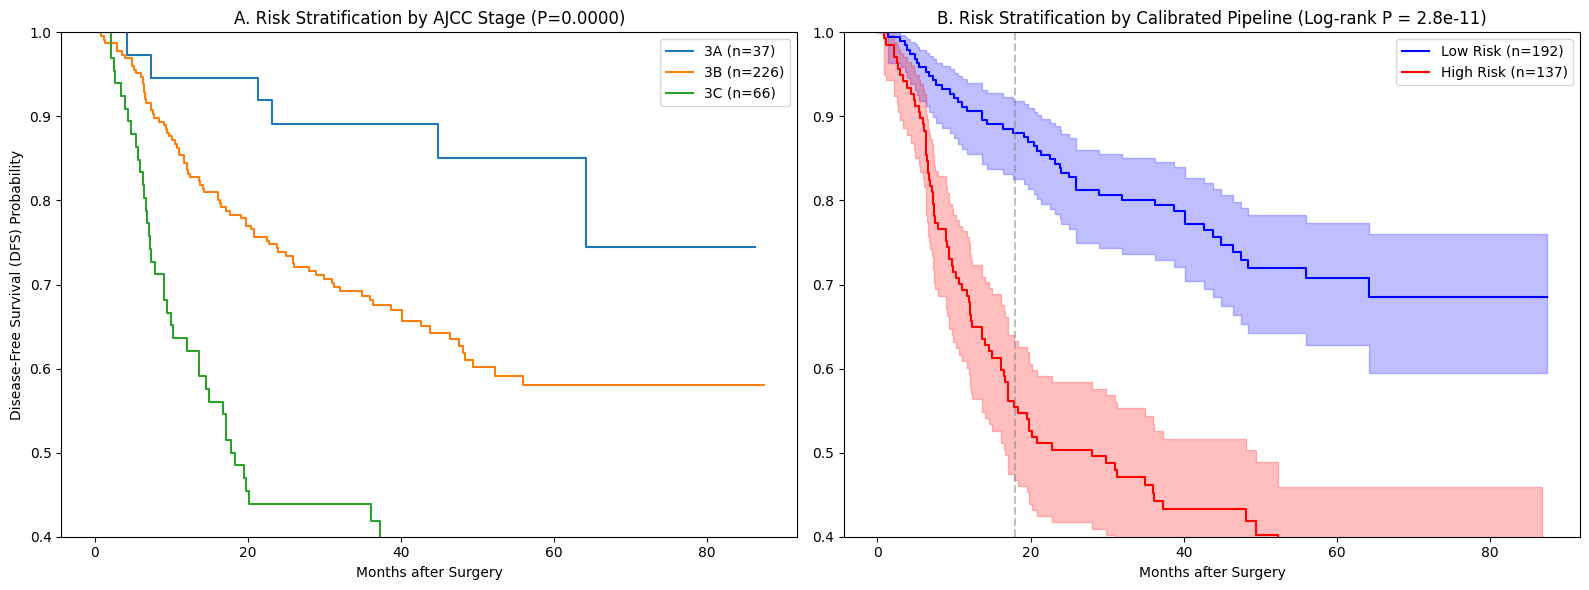


Final Log-rank Test P-value: 2.8316908674806542e-11


In [282]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
import joblib

# 讀取資料
df = pd.read_parquet('all_cases_prepared_for_ML.parquet', engine='pyarrow')

# ==========================================
# 1. 準備全量數據
# ==========================================
features = ['AJCC_Substage', 'PNI', 'LNR', 'Differentiation']

# 確保時間與事件存在
cols_needed = features + ['edr_18m', 'DFS_Months', 'Recurrence', 'Death']
df_clean = df[cols_needed].copy()

# 只刪除沒有 Target (edr_18m) 的資料
df_train = df_clean.dropna(subset=['edr_18m']).copy()

X = df_train[features].copy()
y = df_train['edr_18m'].astype(int)

print(f"訓練集樣本數 (N): {len(X)}")

# --- 前處理 (Preprocessing) ---
# 1. 轉數值
X['PNI'] = pd.to_numeric(X['PNI'], errors='coerce')
X['Differentiation'] = pd.to_numeric(X['Differentiation'], errors='coerce')

# 2. One-Hot Encoding (手動處理確保 App 端一致性)
# 這裡我們在 Pipeline 之外處理 One-Hot，因為這屬於特徵工程的一環
# App 端也必須送入這三個欄位
X = pd.get_dummies(X, columns=['AJCC_Substage'])

# 3. 清洗無限大
X.replace([np.inf, -np.inf], np.nan, inplace=True)

feature_columns = X.columns.tolist()
joblib.dump(feature_columns, 'final_feature_columns.pkl')
print("✅ 已儲存 feature_columns -> final_feature_columns.pkl")

# 注意：這裡不再先做 fit_transform，而是把 Imputer 定義好放進 Pipeline
# X 現在是可以包含 NaN 的

# ==========================================
# 2. 建立並訓練最終 Pipeline
# ==========================================
ratio = float(y.value_counts()[0] / y.value_counts()[1])

# (A) 定義基礎 XGBoost
xgb_base = XGBClassifier(
    n_estimators=50,
    max_depth=2,
    learning_rate=0.05,
    min_child_weight=1,
    gamma=1,
    subsample=0.9,
    colsample_bytree=0.6,
    reg_lambda=1,
    reg_alpha=0.5,
    scale_pos_weight=ratio,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=8251,
    n_jobs=-1
)

# (B) 定義校準器
# cv=5 表示內部切 5 份來學校準參數
calibrated_clf = CalibratedClassifierCV(xgb_base, method='isotonic', cv=5)

# (C) 【關鍵修正】建立 Pipeline (補值 -> 校準預測)
final_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),  # 步驟 1: 補值
    ('model', calibrated_clf)                # 步驟 2: 校準後的模型
])

print("正在訓練 Pipeline (包含 KNN 補值與機率校準)...")
# 直接把含有缺值的 X 丟進去，Pipeline 會自動處理
final_pipeline.fit(X, y)

fitted_imputer = final_pipeline.named_steps['imputer']
joblib.dump(fitted_imputer, 'final_knn_imputer.pkl')
print("✅ 已儲存 KNNImputer -> final_knn_imputer.pkl")

# (D) 預測 (使用訓練好的 Pipeline)
y_pred_prob = final_pipeline.predict_proba(X)[:, 1]

# 將校準後的機率存回 df_train
df_train['ML_Prob'] = y_pred_prob

# (E) 儲存 Pipeline (這才是真正要給 App 用的檔案)
joblib.dump(final_pipeline, 'final_model_calibrated.pkl')
print("✅ 包含補值功能的完整 Pipeline 已儲存為 'final_model_calibrated.pkl'")


# ==========================================
# 3. 重算 Cutoff
# ==========================================
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
j_scores = tpr + (1 - fpr) - 1
best_idx = np.argmax(j_scores)
best_cutoff = thresholds[best_idx]

print(f"\n【最終參數】")
print(f"Training AUC: {roc_auc_score(y, y_pred_prob):.4f}")
print(f"Best Cutoff (Youden): {best_cutoff:.4f}")

# ==========================================
# 4. 畫圖階段 (KM Plot)
# ==========================================
df_plot = df_train.dropna(subset=['DFS_Months', 'Recurrence']).copy()
print(f"畫圖用樣本數 (N): {len(df_plot)}")

# 定義 DFS Event
# 只要 Recurrence 是 1 或者 Death 是 1，DFS Event 就是 1
df_plot['DFS_Event'] = (df_plot['Recurrence'] == 1) | (df_plot['Death'] == 1)
df_plot['DFS_Event'] = df_plot['DFS_Event'].astype(int)

# 移除時間或事件有缺值的 (雖然理論上不該有)
df_plot.dropna(subset=['DFS_Months', 'DFS_Event'], inplace=True)

print(f"DFS 分析總人數: {len(df_plot)}")
print(f"DFS Events 總數 (復發+死亡): {df_plot['DFS_Event'].sum()}")
print(f"(原本單純復發數: {df_plot['Recurrence'].sum()})")

T = df_plot['DFS_Months']
E = df_plot['DFS_Event']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
kmf = KaplanMeierFitter()

# --- 左圖：AJCC ---
ax = axes[0]
if 'AJCC_Substage' in df_plot.columns:
    for group in sorted(df_plot['AJCC_Substage'].unique()):
        mask = df_plot['AJCC_Substage'] == group
        if mask.sum() > 0:
            kmf.fit(T[mask], E[mask], label=f"{group} (n={mask.sum()})")
            kmf.plot_survival_function(ax=ax, ci_show=False)
    
    results_ajcc = multivariate_logrank_test(df_plot['DFS_Months'], df_plot['AJCC_Substage'], df_plot['Recurrence'])
    ax.set_title(f"A. Risk Stratification by AJCC Stage (P={results_ajcc.p_value:.4f})")
else:
    ax.set_title("A. Risk Stratification by AJCC Stage")

ax.set_xlabel("Months after Surgery")
ax.set_ylabel("Disease-Free Survival (DFS) Probability")
ax.set_ylim(0.4, 1.0)

# --- 右圖：ML Pipeline ---
ax = axes[1]

high_risk = df_plot['ML_Prob'] >= best_cutoff
low_risk = df_plot['ML_Prob'] < best_cutoff

kmf.fit(T[low_risk], E[low_risk], label=f"Low Risk (n={low_risk.sum()})")
kmf.plot_survival_function(ax=ax, color='blue', ci_show=True)

kmf.fit(T[high_risk], E[high_risk], label=f"High Risk (n={high_risk.sum()})")
kmf.plot_survival_function(ax=ax, color='red', ci_show=True)

lr_result = logrank_test(T[low_risk], T[high_risk], E[low_risk], E[high_risk])
p_val = lr_result.p_value

ax.set_title(f"B. Risk Stratification by Calibrated Pipeline (Log-rank P = {p_val:.1e})")
ax.set_xlabel("Months after Surgery")
ax.set_ylim(0.4, 1.0)
ax.axvline(x=18, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('km_plot_pipeline_final.png', dpi=300)
plt.show()

print(f"\nFinal Log-rank Test P-value: {p_val}")

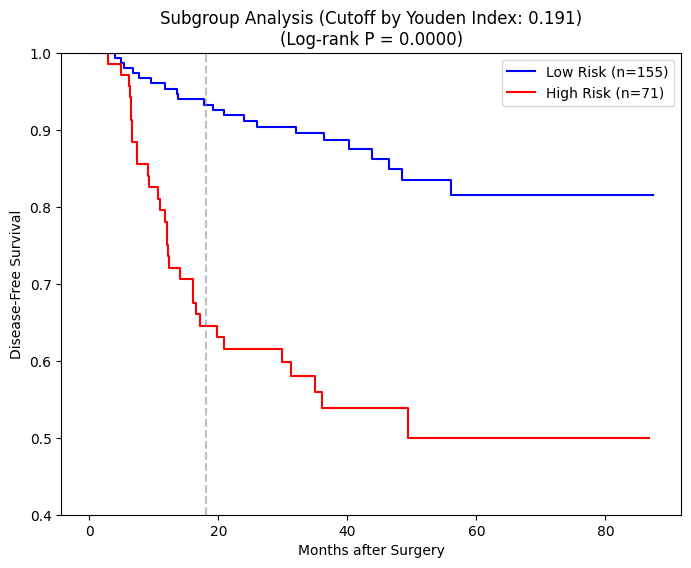

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# 篩選 IIIB 亞組 (如果您還沒跑之前的 code，這行要確認變數存在)
# 假設 df_clean['AJCC_Substage'] 裡面的文字有 'B'
subgroup_mask = df_plot['AJCC_Substage'].astype(str).str.contains('B')
df_subgroup = df_plot[subgroup_mask].copy()

cutoff=0.191

high_risk_sub = df_subgroup['ML_Prob'] >= cutoff
low_risk_sub = df_subgroup['ML_Prob'] < cutoff

plt.figure(figsize=(8, 6))
ax = plt.gca()
kmf = KaplanMeierFitter()

# 畫 Low Risk
kmf.fit(df_subgroup.loc[low_risk_sub, 'DFS_Months'], 
        df_subgroup.loc[low_risk_sub, 'Recurrence'], 
        label=f"Low Risk (n={low_risk_sub.sum()})")
kmf.plot_survival_function(ax=ax, color='blue', ci_show=False)

# 畫 High Risk
kmf.fit(df_subgroup.loc[high_risk_sub, 'DFS_Months'], 
        df_subgroup.loc[high_risk_sub, 'Recurrence'], 
        label=f"High Risk (n={high_risk_sub.sum()})")
kmf.plot_survival_function(ax=ax, color='red', ci_show=False)

# P-value
lr_result = logrank_test(df_subgroup.loc[low_risk_sub, 'DFS_Months'], 
                         df_subgroup.loc[high_risk_sub, 'DFS_Months'], 
                         df_subgroup.loc[low_risk_sub, 'Recurrence'], 
                         df_subgroup.loc[high_risk_sub, 'Recurrence'])

plt.title(f"Subgroup Analysis (Cutoff by Youden Index: {cutoff:.3f})\n(Log-rank P = {lr_result.p_value:.4f})")
plt.xlabel("Months after Surgery")
plt.ylabel("Disease-Free Survival")
plt.axvline(x=18, color='gray', linestyle='--', alpha=0.5)
plt.ylim(0.4, 1.0)
plt.show()

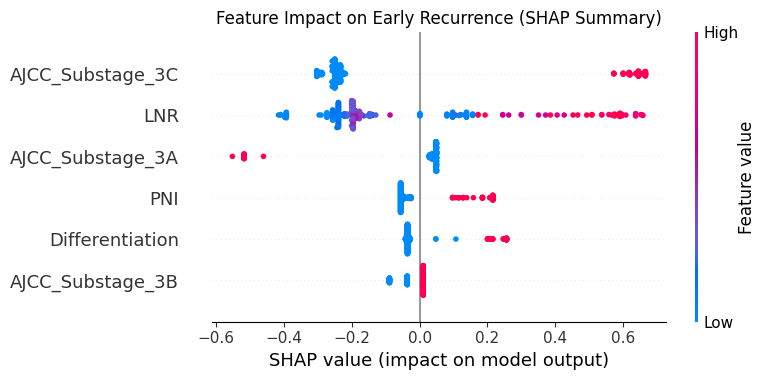

In [243]:
import shap
import matplotlib.pyplot as plt

xgb_base.fit(X_imputed, y)

# 計算 SHAP 值
explainer = shap.TreeExplainer(xgb_base)
shap_values = explainer.shap_values(X_imputed)

# 3. 畫圖
plt.figure(figsize=(10, 8))
plt.title("Feature Impact on Early Recurrence (SHAP Summary)")
shap.summary_plot(shap_values, X_imputed, show=False)

# 調整一下排版讓字不被切掉
plt.tight_layout()
plt.show()